In [2]:
%load_ext autoreload
%load_ext watermark

In [3]:
%autoreload 2

In [4]:
%watermark -ntz -p matplotlib,numpy,pandas,scipy

Fri Aug 05 2022 11:07:36 India Standard Time 

matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
scipy 1.4.1


In [5]:
import datetime
import math
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

---
# Exercise 5: Explore Correlations
In previous exercises,
you have investigated weather and traffic data separately.
In this exercise,
you will combine the datasets
and investigate correlations between them.

## Learning objectives
Objectives which _may_ be met during this exercise.

_Refer to the [exercise document](../references/exercise_background.md#development-objectives) for more information on objectives_


---
## Step 1: Load data

**Tasks:**
- Load traffic data
- Add columns for `month`, `weekday`, `hour`
- Turn `Date` column into date only (no time)
- Repeat with weather data

In [6]:
#data_path = None  # TODO
#traffic_data_path = None
#weather_data_path = None

traffic_data_path = Path.cwd().resolve().parent /'analysis' / "data" / "interim" / "counter_data.csv"
weather_data_path = Path.cwd().resolve().parent /'analysis'/ "data" / "interim" / "weather_data_i.csv"

In [7]:

traffic_df = pd.read_csv(traffic_data_path)

traffic_df["Date" ] = pd.to_datetime(traffic_df["Date"])

#Original time is end of a timespan, subtract 1 hour to get start of period. 
#This reduces drawing artifacts where the last hour of each day has next days date.
traffic_df["Date"] = traffic_df["Date"] - pd.Timedelta(hours=1)

# TODO add month, weekday, hour columns
# TODO turn "Date" column into date only (i.e. year, month, day)
traffic_df['Month'] = traffic_df['Date'].apply(lambda x: x.month)
traffic_df['Day'] = traffic_df['Date'].apply(lambda x: x.day)
traffic_df['Weekday'] = traffic_df['Date'].apply(lambda x: x.dayofweek)
traffic_df["Hour"] = traffic_df["Date"].apply(lambda x: x.hour)
traffic_df['Date'] = traffic_df['Date'].apply(lambda d: d.date())
traffic_df.describe(include=["object", "int64", "datetime64[ns]"])

,Date,Hour Ending,Special day,Counter ID,Counts,Month,Day,Weekday,Hour
count,186624,186624.000000,45120,186624.000000,186624.000000,186624.000000,186624.000000,186624.000000,186624.000000
unique,365,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-07-02,NaN,o,NaN,NaN,NaN,NaN,NaN,NaN
freq,576,NaN,40416,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,12.500000,NaN,44059.051569,116.501983,6.636574,15.743699,3.002829,11.500000
std,NaN,6.922205,NaN,13443.770875,181.584278,3.381432,8.760233,2.000775,6.922205
min,NaN,1.000000,NaN,20011.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,6.750000,NaN,30023.000000,8.000000,4.000000,8.000000,1.000000,5.750000
50%,NaN,12.500000,NaN,50011.000000,49.000000,7.000000,16.000000,3.000000,11.500000
75%,NaN,18.250000,NaN,50077.000000,137.000000,10.000000,23.000000,5.000000,17.250000


In [23]:
traffic_df

,Date,Hour Ending,Special day,Counter ID,Counts,Month,Day,Weekday,Hour
0,2019-01-01,1,bo,20011,12,1,1,1,0
1,2019-01-01,2,bo,20011,10,1,1,1,1
2,2019-01-01,3,bo,20011,2,1,1,1,2
3,2019-01-01,4,bo,20011,8,1,1,1,3
4,2019-01-01,5,bo,20011,2,1,1,1,4
...,...,...,...,...,...,...,...,...,...
186619,2019-12-31,20,o,60006,6,12,31,1,19
186620,2019-12-31,21,o,60006,6,12,31,1,20
186621,2019-12-31,22,o,60006,2,12,31,1,21
186622,2019-12-31,23,o,60006,0,12,31,1,22


Load weather data

In [15]:
#weather_df = None
weather_df = pd.read_csv(weather_data_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
weather_df["Month"] = weather_df["Date"].apply(lambda d: d.month)
weather_df["Day"] = weather_df["Date"].apply(lambda d: d.weekday)
weather_df["Hour"] = weather_df["Date"].apply(lambda d: d.hour)
weather_df["Date"] = weather_df["Date"].apply(lambda d: d.date())

In [16]:
weather_df['Day']

0      <built-in method weekday of Timestamp object a...
1      <built-in method weekday of Timestamp object a...
2      <built-in method weekday of Timestamp object a...
3      <built-in method weekday of Timestamp object a...
4      <built-in method weekday of Timestamp object a...
                             ...                        
360    <built-in method weekday of Timestamp object a...
361    <built-in method weekday of Timestamp object a...
362    <built-in method weekday of Timestamp object a...
363    <built-in method weekday of Timestamp object a...
364    <built-in method weekday of Timestamp object a...
Name: Day, Length: 365, dtype: object

---
## Step 2: Calculate monthly correlations
We have provided a shell of a function
which calculated Pearson correlation
between rainfall/temperature
and traffic count,
for a particular month.

**Tasks:**
- Complete function `get_pearson`
- Add a boolean hyperparam (default `False`) called `weekend_only`,
which only includes data from Friday, Saturday, Sunday if `True`
- For all counters,
plot _significant_ (p < 0.05) correlations against month,
for both rainfall and temperature
- What do you notice about the correlations over rainfall and temperature to traffic? What should we do about that?
- Are certain months more strongly correlated with a weather pattern?
- Are certain counting stations more strongly correlated?
- How do correlations change if we only include weekends?
- **\[Extension]** Is it valid to perform many correlation checks in this way? What do we have to be careful of? What would be a more robust method?

In [17]:
def get_pearson(
    month_indices: List[int],
    counters: List[int],
    col_name: str,
    weekend_only=False,
) -> Tuple[float, float, pd.DataFrame]:
    """
    Get Pearson's coefficient between traffic count and the specified weather variable
    
    Parameters
    ----------
    month_index: list of ints
        The index of the month (1-indexed)
    counter: list of ints
        The ID of the counter to track (0-indexed)
    col_name: str
        The name of the weather column to get the coefficient for
    """
    # Filter traffic data on month, counters and potentially day of week
    selected_df = traffic_df.loc[(traffic_df["Month"].isin(month_indices)) & (traffic_df["Counter ID"].isin(counters))]
    if weekend_only:
        selected_df = selected_df.loc[selected_df["Weekday"].isin([4, 5, 6])]
    
    # TODO Sum the counts for all counters
    aggregate_df = None
    aggregate_df = pd.DataFrame()
    # We need an univariate analysis to check for outliers?
    aggregate_df = selected_df.groupby(['Date','Counter ID'],as_index=False).agg({'Counts': ['sum','mean']})

    # Merge weather and aggregated traffic data
    combined_df = weather_df.merge(aggregate_df, on="Date",how = 'right')
    
    # TODO Remove any rows with NaNs in weather feature column or traffic counts column
    combined_df.dropna(subset=[col_name, ('Counts','sum')], inplace=True)
    
    # TODO Get Pearson's coefficient
    # sort it on date, peasron corre @ counter ID level :
    # Hint use `scipy.stats`
    r, p = (None, None)
    if len(combined_df) >= 2:
        r, p = stats.pearsonr(combined_df[col_name], combined_df['Counts'])
    else:
        r = 0.0
        p = 10.0

    return r, p, combined_df

In [19]:
# TODO plot correlations against month for all counters where p < 0.05
print('Pearson for Rainfall')
significant_r = []
significant_counters = []
significant_months = []

for counter in traffic_df["Counter ID"].unique():
    for month in range(1, 13):
        r, p, _ = get_pearson([month], [counter], 'MaxApparentTemp (degC)', weekend_only=True)
        if p < 0.05:
            significant_r.append(r)
            significant_counters.append(counter)
            significant_months.append(month)

#plt.scatter(significant_months, significant_r)
        
    
#print('\nPearson for Max Apparent Temp')
#for i in range(12):
    #r, p, comb_df = get_pearson([i+1], counters, 'MaxApparentTemp (degC)', weekend_only=False)
    #print(f"Month {i + 1}: r = {r}, p = {p}")"""

Pearson for Rainfall


In [20]:
print(significant_r,significant_counters,significant_months)

[-0.5896350347124324, 0.8438159441608688, 0.8353859205193981, 0.7396367013884553, 0.5863679236218747, 0.5521195378179498, 0.5999778538085088, 0.8333841419881811, 0.6511876228773089, 0.6915660313087809, 0.6821518403654026, 0.6025716296674901, 0.7789334538115995, 0.533338047233686, 0.7912291940457847, 0.7615700191196838, 0.7787705039630753, 0.5532394705182933, 0.8083196633421768, 0.79621305220909, 0.7566176135900036, 0.5934844167594866, -0.9995036813410716, 0.5824597712345758, -0.9994302961611992, 0.6214074796067133, 0.735447476691248, 0.7130421990104975, 0.5907055291536836, 0.6951727372635719, 0.6728792293892418, 0.6104504814148481, -0.8042854179017602, 0.7357183689619476, 0.7054059549114523, 0.7606651483525605, 0.7552955588684978, 0.6768233194328583, -0.9993195094764538, 0.7214771032420428, 0.6741818347165811, -0.5996840107516971, 0.8144911027850955, 0.5636426780518609, 0.59755943052621, 0.6743909421837553, 0.6650548149689788, 0.6790460102074514, 0.8547575801479927, 0.5392197814137729,

In [22]:
for i in range(12):
    r, p, comb_df = get_pearson([i+1], [counters], 'MaxApparentTemp (degC)', weekend_only=False)
    print(f"Month {i + 1}: r = {r}, p = {p}")

Month 1: r = 0.07705076217093994, p = 0.6803508153003891
Month 2: r = 0.20637249468885854, p = 0.4267915152845328
Month 3: r = 0.22208781230926236, p = 0.3084448440954695
Month 4: r = 0.4316520808110333, p = 0.01722799288309277
Month 5: r = 0.16511776273130374, p = 0.3747170020413771
Month 6: r = 0.35612653911982883, p = 0.05341310416848148
Month 7: r = 0.9323268577674533, p = 0.020917031983071165
Month 8: r = -0.9776407723017847, p = 0.13487643093929141
Month 9: r = 0.0, p = 10.0
Month 10: r = -0.46072622067200925, p = 0.11309250492594278
Month 11: r = 0.09338026364833815, p = 0.6235632443440109
Month 12: r = -0.053254323259693745, p = 0.7760083578389815


Pearson for Rainfall


C:\Users\ANIRUPAD\Anaconda3\envs\traffic-exercise-dev-test\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


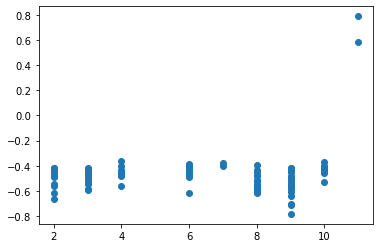

In [25]:
# TODO plot correlations against month for all counters where p < 0.05
print('Pearson for Rainfall')
significant_r = []
significant_counters = []
significant_months = []

for counter in traffic_df["Counter ID"].unique():
    for month in range(1, 13):
        r, p, _ = get_pearson([month], [counter], 'Rainfall (mm)', weekend_only=False)
        if p < 0.05:
            significant_r.append(r)
            significant_counters.append(counter)
            significant_months.append(month)

plt.scatter(significant_months, significant_r)

Pearson for Rainfall


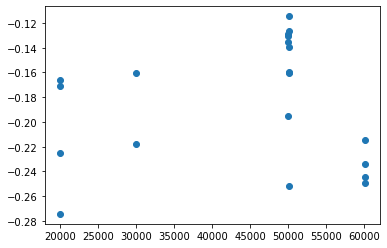

In [29]:
# Getting Significant Correlation for all counters for 12 months:
# TODO plot correlations against month for all counters where p < 0.05
print('Pearson for Rainfall')
significant_r = []
significant_counters = []
significant_months = []
month = [1,2,3,4,5,6,7,8,9,10,11,12]

for counter in traffic_df["Counter ID"].unique():
        r, p, _ = get_pearson(month, [counter], 'Rainfall (mm)', weekend_only=False)
        if p < 0.05:
            significant_r.append(r)
            significant_counters.append(counter)

plt.scatter(significant_counters, significant_r)

Pearson for Temperature


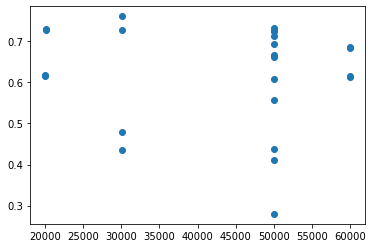

In [30]:
# Getting Significant Correlation for all counters for 12 months:
# TODO plot correlations against month for all counters where p < 0.05
print('Pearson for Temperature')
significant_r = []
significant_counters = []
significant_months = []
month = [1,2,3,4,5,6,7,8,9,10,11,12]

for counter in traffic_df["Counter ID"].unique():
        r, p, _ = get_pearson(month, [counter], 'MaxApparentTemp (degC)', weekend_only=False)
        if p < 0.05:
            significant_r.append(r)
            significant_counters.append(counter)

plt.scatter(significant_counters, significant_r)

Pearson for Rainfall


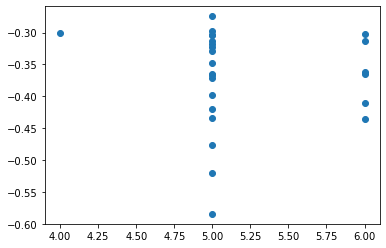

In [31]:
# TODO plot correlations against month for all counters where p < 0.05
print('Pearson for Rainfall')
significant_r = []
significant_counters = []
significant_months = []

for counter in traffic_df["Counter ID"].unique():
    for month in range(0, 24):
        r, p, _ = get_pearson_new('Weekday', [month], [counter], 'Rainfall (mm)', weekend_only=True)
        if p < 0.05:
            significant_r.append(r)
            significant_counters.append(counter)
            significant_months.append(month)

plt.scatter(significant_months, significant_r)

---
## Step 3: Investigate other correlations

**Tasks:**
- Extend `get_pearson_ to accept a parameter which determines over what timescale (e.g. `month`, `weekday`, `hour`) correlations should be measured

In [24]:
def get_pearson_new( timescale : str,
    indices: List[int],
    counters: List[int],
    col_name: str,
    weekend_only=False,
) -> Tuple[float, float, pd.DataFrame]:
    """
    Get Pearson's coefficient between traffic count and the specified weather variable
    
    Parameters
    ----------
    timescale : str
    Month, Weekday, Hour : over which kind of time zone you want your data to be group by for correlation
    index: list of ints
        The index of the month (1-indexed), weekday or hours you want to calculate correlation on
    counter: list of ints
        The ID of the counter to track (0-indexed)
    col_name: str
        The name of the weather column to get the coefficient for
    """
    # Filter traffic data on month, counters and potentially day of week
    if timescale == 'Month' :
        selected_df = traffic_df.loc[(traffic_df["Month"].isin(indices)) & (traffic_df["Counter ID"].isin(counters))]
    if timescale == 'Weekday':
        selected_df = traffic_df.loc[(traffic_df["Weekday"].isin(indices)) & (traffic_df["Counter ID"].isin(counters))]
    if timescale == 'Hour':
        selected_df = traffic_df.loc[(traffic_df["Hour"].isin(indices)) & (traffic_df["Counter ID"].isin(counters))]
    if weekend_only:
        selected_df = selected_df.loc[selected_df["Weekday"].isin([4, 5, 6])]
    
    # TODO Sum the counts for all counters
    aggregate_df = None
    aggregate_df = pd.DataFrame()
    aggregate_df = selected_df.groupby('Date').agg({'Counts': 'sum'})

    # Merge weather and aggregated traffic data
    combined_df = weather_df.merge(aggregate_df, on="Date")
    
    # TODO Remove any rows with NaNs in weather feature column or traffic counts column
    combined_df.dropna(subset=[col_name, 'Counts'], inplace=True)
    
    # TODO Get Pearson's coefficient
    # Hint use `scipy.stats`
    r, p = (None, None)
    if len(combined_df) >= 2:
        r, p = stats.pearsonr(combined_df[col_name], combined_df['Counts'])
    else:
        r = 0.0
        p = 10.0

    return r, p, combined_df

---
# Review